# **Ansatz Circuit Configuration Testbench - Quantum Machine Learning Capstone 2022**

#### **Capstone Members ⸻** Carson Darling, Brandon Downs, Christopher Haddox, Brightan Hsu, Matthew Jurenka

#### **Sponsor ⸻** Dr. Gennaro De Luca

<br>


## **Introduction**

The purpose of this Jupyter Notebook is to serve as a testbench for the quantum machine learning capstone group. This testbench allows for the testing of a quantum variational classifier with different ansatz configurations on three different datasets. Each dataset consists of instances containing a binary classification over 4 numeric features. The circuits will all exhibit rotational encoding over 4 qubits, allowing a qubit for each feature. The datasets are as follows:

&emsp;&emsp;[Iris Dataset](https://archive.ics.uci.edu/ml/datasets/iris) ⸻ 3 classes of 150 instances of plant measures, where each class refers to a type of iris plant. This dataset will be truncated to only 2 classes.

&emsp;&emsp;[Banknote Dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication)⸻ 2 classes consisting of 1372 instances of banknote-like specimen, where each class refers to forgery or authenticate.

&emsp;&emsp;[Transfusion Dataset](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center) ⸻ 2 classes consisting of 748 donors from the donor database, where each class refers to donation in March 2007.
<br>

### Packages and Non-Standard Python Package Installation

The non-standard python packages used by this TestBench are TQDM, SKLearn, Pennylane, and Pandas.
Uncomment and execute the method **clean_install()** to execute the installation via PIP. The environment must have Python 3.6+ and PIP installed.

In [17]:
import subprocess
import sys

def pip_install(package):
    subprocess.run([sys.executable, "-m", "pip", "install", package])

def clean_install():
    [pip_install(package)
     for package in ['tqdm', 'sklearn', 'pennylane', 'pandas', 'pennylane-qiskit', 'pylatexenc']]

#clean_install()

In [18]:
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm_notebook
from pennylane import numpy as np
import pennylane as qml
import random as rand
import time as time
import pandas as pd
import os as os

## **Methodology**


### **Independent Variables**


In [19]:
# Relating to the tests
NUM_ITERATIONS = 1

# Relating to Circuit Configurations
NUM_QUBITS = 4

# Relating to the Variational Classifier
NUM_LAYERS = 6
BATCH_SIZE = 5
STEP_SIZE = .1
MAX_EPOCHS = 100
BIAS_INIT = np.array(0.0, requires_grad=True)
WEIGHTS_INIT = 0.01 * np.random.randn(NUM_LAYERS, NUM_QUBITS, 3, requires_grad=True)

# Relating to the datasets
paths = ['~/Documents/QML/iris.data', '~/Documents/QML/banknote.data',
         '~/Documents/QML/transfusion.data']
DATAFRAMES = [((os.path.splitext(os.path.basename(path))[0]).capitalize(), pd.read_csv(
    path, names=['a0', 'a1', 'a2', 'a3', 'target'])) for path in paths]

### **Dependent Variable** - Ansatz Circuit Configuration


This global variable will serve as a function reference to a specific tested ansatz circuit configuration during test iterations. The implementation of function reference serves for increased readability in circuit configurations by encapsulating encoding techniques within a circuit configuration.


In [20]:
CURRENT_TEST_CIRCUIT = None

### **Ansatz Circuit Configuration Library**


In [21]:
TEST_DEVICE = qml.device("default.qubit", wires=NUM_QUBITS)
circuit_library = []

In [22]:
def rotational_encoding(x):
    qml.Rot(x[0], x[0], x[0], wires=0)
    qml.Rot(x[1], x[1], x[1], wires=1)
    qml.Rot(x[2], x[2], x[2], wires=2)
    qml.Rot(x[3], x[3], x[3], wires=3)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])
    return np.array(x)

In [23]:
draw_device = qml.device("qiskit.aer", wires=NUM_QUBITS)
draw_weight_shape = qml.templates.StronglyEntanglingLayers.shape(n_layers=2, n_wires=4)
draw_weights = np.random.random(draw_weight_shape)
draw_features = [0,0,0,0]

#### Pennylane Layered Circuit

(<Figure size 1296x360 with 1 Axes>, <Axes:>)


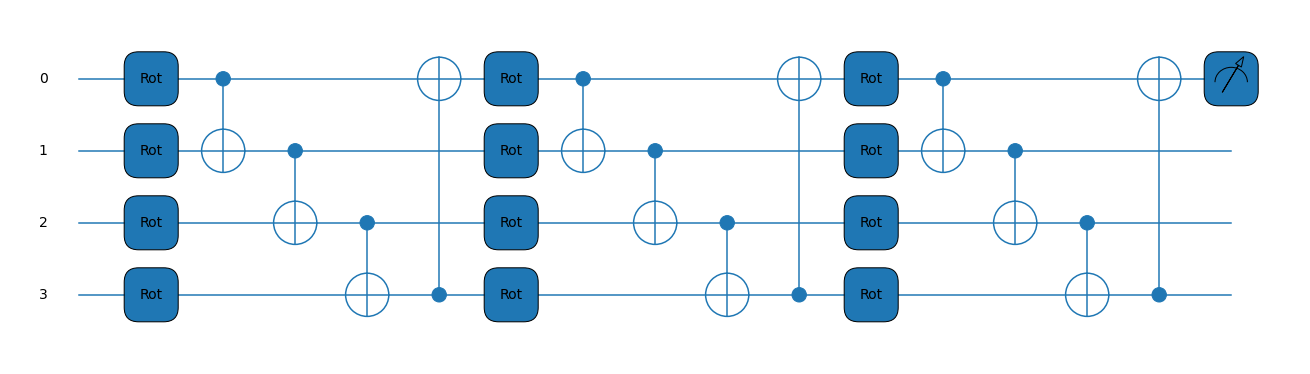

In [24]:
# Pennylane Circuit from Quantum Variational Classifier
def pennylane_circuit(weights, features):

    rotational_encoding(features)

    for W in weights:
        qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
        qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
        qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
        qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)
        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[2, 3])
        qml.CNOT(wires=[3, 0])

    return qml.expval(qml.PauliZ(0))


circuit_library.append(pennylane_circuit)
temp_circuit = qml.QNode(pennylane_circuit, draw_device)
print(qml.draw_mpl(temp_circuit)(draw_weights, draw_features))


#### Hardware Efficient Circuit

(<Figure size 1800x360 with 1 Axes>, <Axes:>)


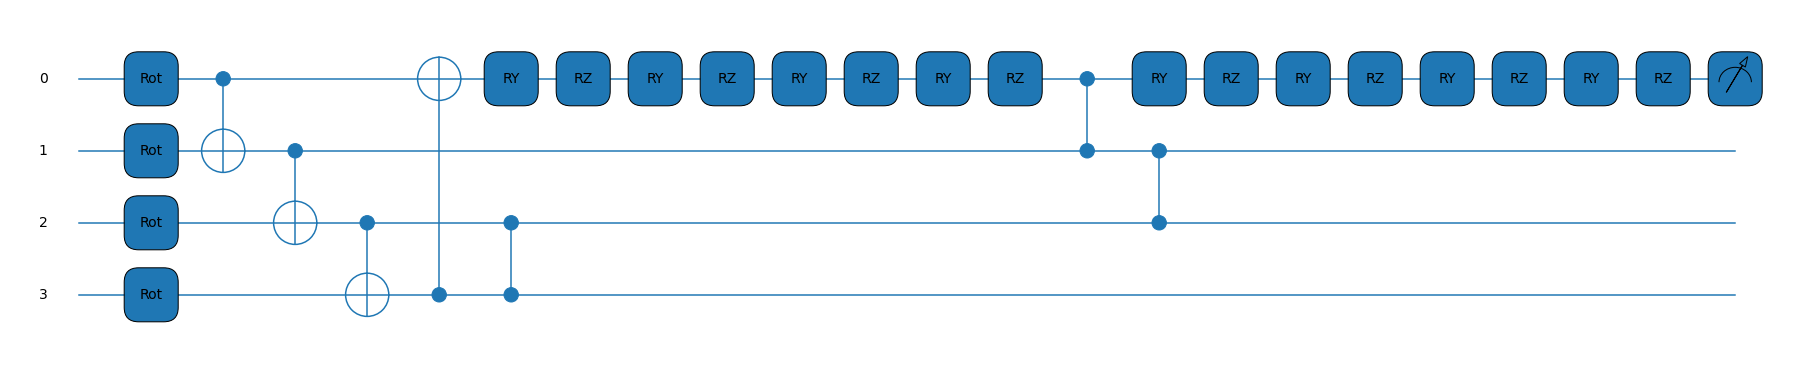

In [25]:
def hardware_efficient_circuit(weights, features):
    rotational_encoding(features)

    for W in weights[:-1]:
        qml.RY(W[0, 0], wires=0)
        qml.RZ(W[0, 1], wires=0)
        qml.RY(W[1, 0], wires=0)
        qml.RZ(W[1, 1], wires=0)
        qml.RY(W[2, 0], wires=0)
        qml.RZ(W[2, 1], wires=0)
        qml.RY(W[3, 0], wires=0)
        qml.RZ(W[3, 1], wires=0)
        qml.CZ(wires=[0, 1])
        qml.CZ(wires=[2, 3])
        qml.CZ(wires=[1, 2])

    W = weights[-1]
    qml.RY(W[0, 0], wires=0)
    qml.RZ(W[0, 1], wires=0)
    qml.RY(W[1, 0], wires=0)
    qml.RZ(W[1, 1], wires=0)
    qml.RY(W[2, 0], wires=0)
    qml.RZ(W[2, 1], wires=0)
    qml.RY(W[3, 0], wires=0)
    qml.RZ(W[3, 1], wires=0)

    return qml.expval(qml.PauliZ(0))

circuit_library.append(hardware_efficient_circuit)
temp_circuit = qml.QNode(hardware_efficient_circuit, draw_device)
print(qml.draw_mpl(temp_circuit)(draw_weights, draw_features))




#### Pennylane AB parameterized Circuit

(<Figure size 1152x360 with 1 Axes>, <Axes:>)


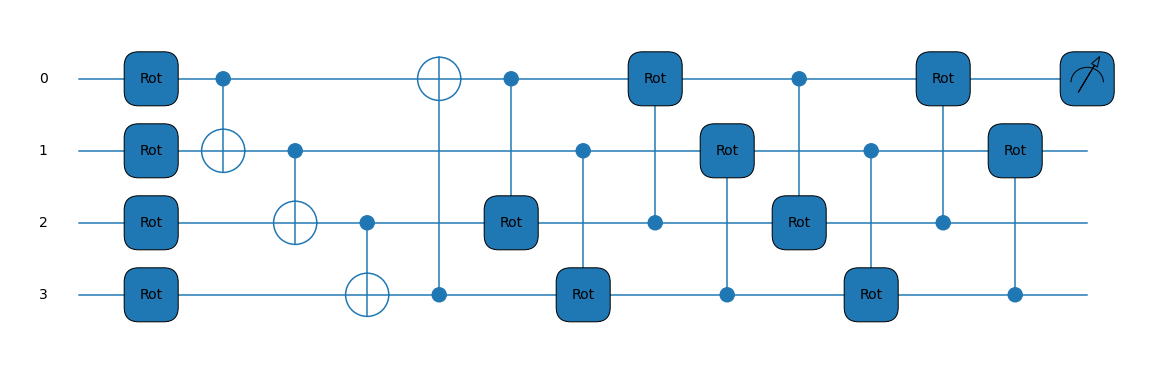

In [26]:
# https://pennylane.ai/qml/glossary/circuit_ansatz.html#a-parametrized-b-parametrized
def pennylane_ab_parameterized_circuit(weights, features):
    rotational_encoding(features)

    for W in weights:
        qml.CRot(W[0, 0], W[0, 1], W[0, 2], wires=[0, 2])
        qml.CRot(W[1, 0], W[1, 1], W[1, 2], wires=[1, 3])
        qml.CRot(W[2, 0], W[2, 1], W[2, 2], wires=[2, 0])
        qml.CRot(W[3, 0], W[3, 1], W[3, 2], wires=[3, 1])

    return qml.expval(qml.PauliZ(0))


circuit_library.append(pennylane_ab_parameterized_circuit)
temp_circuit = qml.QNode(pennylane_ab_parameterized_circuit, draw_device)
print(qml.draw_mpl(temp_circuit)(draw_weights, draw_features))

#### Pairwise Controlled Rotation Circuit

(<Figure size 2304x360 with 1 Axes>, <Axes:>)


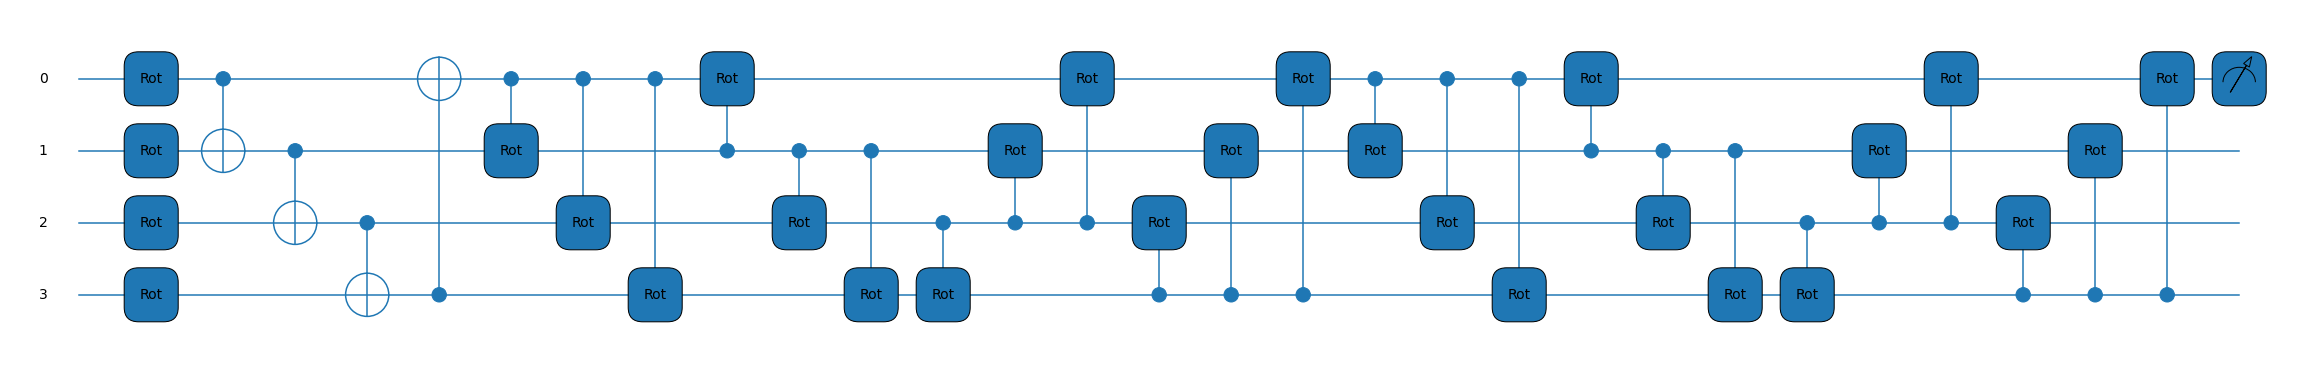

In [27]:
# https://arxiv.org/pdf/1612.02806.pdf
def pairwise_controlled_rot_circuit(weights, features):
    rotational_encoding(features)

    for W in weights:
        qml.CRot(W[0, 0], W[0, 1], W[0, 2], wires=[0, 1])
        qml.CRot(W[0, 0], W[0, 1], W[0, 2], wires=[0, 2])
        qml.CRot(W[0, 0], W[0, 1], W[0, 2], wires=[0, 3])

        qml.CRot(W[1, 0], W[1, 1], W[1, 2], wires=[1, 0])
        qml.CRot(W[1, 0], W[1, 1], W[1, 2], wires=[1, 2])
        qml.CRot(W[1, 0], W[1, 1], W[1, 2], wires=[1, 3])

        qml.CRot(W[2, 0], W[2, 1], W[2, 2], wires=[2, 3])
        qml.CRot(W[2, 0], W[2, 1], W[2, 2], wires=[2, 1])
        qml.CRot(W[2, 0], W[2, 1], W[2, 2], wires=[2, 0])

        qml.CRot(W[3, 0], W[3, 1], W[3, 2], wires=[3, 2])
        qml.CRot(W[3, 0], W[3, 1], W[3, 2], wires=[3, 1])
        qml.CRot(W[3, 0], W[3, 1], W[3, 2], wires=[3, 0])

    return qml.expval(qml.PauliZ(0))

circuit_library.append(pairwise_controlled_rot_circuit)
temp_circuit = qml.QNode(pairwise_controlled_rot_circuit, draw_device)
print(qml.draw_mpl(temp_circuit)(draw_weights, draw_features))

### **Data and Preprocessing**

In [28]:
def preprocess(df):

    df.target = df.target.map(
        {df.target.unique()[0]: -1, df.target.unique()[1]: 1})

    if df.target.value_counts()[-1] >= 100 and df.target.value_counts()[1] >= 100:
        df = pd.concat([
            df[(df.target == -1)].sample(n=100, replace=False,
                                         random_state=rand.randint(0, 100)),
            df[(df.target == 1)].sample(n=100, replace=False,
                                        random_state=rand.randint(0, 100))
        ])
    else:
        df = df[(df.target == -1) | (df.target == 1)]

    X = np.array(df)[:, 0:4]
    features = 2 * np.pi * (X - np.min(X)) / (np.max(X) - np.min(X))
    labels = np.array(df)[:, -1]

    return features, labels

### **Optimization**

In [29]:
OPTIMIZERS = [qml.optimize.AdamOptimizer(STEP_SIZE),
              qml.optimize.AdagradOptimizer(STEP_SIZE),
              qml.optimize.GradientDescentOptimizer(STEP_SIZE),
              qml.optimize.NesterovMomentumOptimizer(STEP_SIZE)]

### **Quantum Variational Classifier**


Below is the variational classifier and its supporting functions. This variational classifier model is adapted from the [pennylane variational classifier demo](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html).


In [30]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss


def variational_classifier(weights, bias, angles):
    return CURRENT_TEST_CIRCUIT(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)


In [31]:
header_template = '\t{:<7}   {:<7}   {:<16}   {:<15}'
bar_format="{bar}{n_fmt}/{total_fmt} [{desc} {elapsed}, {rate_fmt}]"
circuit_results = pd.DataFrame(columns=['circuit', 'optimizer', 'dataset', 'iteration', 'epoch', 'cost', 'train_accuracy', 'test_accuracy'])


def print_header():
    # Print the header for the current Iteration
    print(header_template.replace(':', ':-').format('', '', '', ''))
    print(header_template.format(
        *['Epoch', 'Cost', 'Train_Accuracy', 'Test_Accuracy']))
    print(header_template.replace(':', ':-').format('', '', '', ''))

def train_classifier(dataset, circuit, optimizer_index, iteration):

    global CURRENT_TEST_CIRCUIT
    CURRENT_TEST_CIRCUIT = qml.QNode(circuit, TEST_DEVICE)
    optimizer = OPTIMIZERS[optimizer_index]

    # Preprocess the data and seperate into train and test sets. Initialize the weights, bias.
    features, labels = preprocess(dataset[1])
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.25, random_state=rand.randint(0, 100))
    weights, bias = WEIGHTS_INIT, BIAS_INIT
    max_cost = max_train = max_test = 0

    epoch_progress = tqdm_notebook(range(MAX_EPOCHS), desc='Progress', bar_format=bar_format)

    with epoch_progress as pbar:

        print(f'{circuit.__name__} | {OPTIMIZERS[optimizer_index]} | {dataset[0]} | It {iteration}')
        for epoch_index in range(MAX_EPOCHS):

            if not epoch_index:
                print_header()

            # Update the weights by one optimizer step
            batch_index = np.random.randint(0, len(X_train), (BATCH_SIZE,))

            X_train_batch = X_train[batch_index]
            y_train_batch = y_train[batch_index]
            weights, bias, _, _ = optimizer.step(
                cost, weights, bias, X_train_batch, y_train_batch)

            # Compute predictions on train and validation set
            predictions_train = [np.sign(variational_classifier(
                weights, bias, value)) for value in X_train]
            predictions_test = [np.sign(variational_classifier(
                weights, bias, value)) for value in X_test]

            # Compute accuracy on train and validation set
            accuracy_train = accuracy(y_train, predictions_train)
            accuracy_test = accuracy(y_test, predictions_test)
            epoch_cost = cost(weights, bias, features, labels)

            # Tabulate a summary of the current epoch
            print(header_template.format(*[f'{epoch_index:4d}', f'{epoch_cost:0.3f}',
                f'{accuracy_train:0.7f}', f'{accuracy_test:0.7f}']))

            global circuit_results
            circuit_results = circuit_results.append({'circuit':circuit.__name__, 'optimizer':optimizer_index, 'dataset':dataset[0], 'iteration':iteration, 'epoch':epoch_index, 'cost':epoch_cost, 'train_accuracy':accuracy_train, 'test_accuracy':accuracy_test}, ignore_index=True)

            # Break if train and test validation is 100% accuracy.
            if accuracy_test == accuracy_train == 1:
                pbar.update(MAX_EPOCHS-epoch_index)
                pbar.close()
                break
            else:
                pbar.update(1)






### **Test Execution**


In [32]:
def TEST(circuit):

    for dataset_index, dataset in enumerate(DATAFRAMES):

        for optimizer_index, optimizer in enumerate(OPTIMIZERS):

            for iteration in range(NUM_ITERATIONS):

                train_classifier(dataset, circuit, optimizer_index, iteration)

            TEST_DEVICE.reset()

TEST(pennylane_circuit)

          0/100 [Progress 00:00, ?it/s]

pennylane_circuit | <pennylane.optimize.adam.AdamOptimizer object at 0x7f68e4474f40> | Iris | It 0
	-------   -------   ----------------   ---------------
	Epoch     Cost      Train_Accuracy     Test_Accuracy  
	-------   -------   ----------------   ---------------
	   0      2.221     0.0800000          0.1600000      
	   1      1.634     0.2133333          0.2400000      
	   2      0.973     0.6000000          0.6800000      
	   3      0.674     0.8400000          0.8800000      
	   4      0.572     0.9066667          0.9200000      
	   5      0.465     0.9600000          0.9600000      
	   6      0.442     0.9733333          0.9600000      
	   7      0.461     0.9866667          1.0000000      
	   8      0.408     1.0000000          1.0000000      


          0/100 [Progress 00:00, ?it/s]

pennylane_circuit | <pennylane.optimize.adam.AdamOptimizer object at 0x7f68e4474f40> | Banknote | It 0
	-------   -------   ----------------   ---------------
	Epoch     Cost      Train_Accuracy     Test_Accuracy  
	-------   -------   ----------------   ---------------


KeyboardInterrupt: 

             circuit optimizer dataset iteration epoch                cost  \
4  pennylane_circuit         0    Iris         0     4  0.5719653838006475   
5  pennylane_circuit         0    Iris         0     5  0.4645665500504492   
6  pennylane_circuit         0    Iris         0     6  0.4423009921078499   
7  pennylane_circuit         0    Iris         0     7  0.4607528075489402   
8  pennylane_circuit         0    Iris         0     8  0.4080805969923232   

   train_accuracy  test_accuracy  
4        0.906667           0.92  
5        0.960000           0.96  
6        0.973333           0.96  
7        0.986667           1.00  
8        1.000000           1.00  


## **Results**

#qml.metric_tensor
https://arxiv.org/abs/2103.15191

tket library??


## **Discussion**

## **Conclusion**
